In [29]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import glob
import numpy.linalg as LA

In [30]:
def get_file_names(dir_name,image_num):
    names=[]
    for name in glob.glob(f'./images/{dir_name}/{image_num}_*.*'):
        names.append(name)
    return sorted(names)

# Question-1

## Uses inbuilt sift function and returns the matches

In [154]:
def match(img1, img2):
    sift = cv2.xfeatures2d.SIFT_create()
    key1, d1 = sift.detectAndCompute(img1, None)
    key2, d2 = sift.detectAndCompute(img2, None)
    
    matcher = cv2.BFMatcher()
    matches = matcher.knnMatch(d1, d2, k=2)
    inds = []
    for a, b in matches:
        if a.distance < 0.75*b.distance:
            inds.append((a.queryIdx, a.trainIdx))
    
    return key1, key2, np.array(inds)

###  Uses the matched indices of two images obtained in match function and returns corresponding co-ordinates

In [5]:
def get_coords(key1, key2,inds):
    pts1, pts2 = [], []
    for i in range(inds.shape[0]):
        pts1.append(key1[inds[i, 0]].pt)
        pts2.append(key2[inds[i, 1]].pt)
    pts1 = np.array(pts1)
    pts2 = np.array(pts2)
    
    return pts1, pts2

## Homography matrix in naive method

In [218]:
def get_homography(pts1,pts2):
    pts1_h = np.insert(pts1,2,1,axis=1)
    t = np.stack((pts1_h,pts1_h),2).transpose(0,2,1).reshape(2*pts1_h.shape[0],3)
    mat = np.hstack((t,t,t))
    temp = np.tile(np.hstack((np.vstack((-1*np.ones(3),np.zeros(3))),np.vstack((np.zeros(3),-1*np.ones(3))))),(pts2.shape[0],1))
    im_mat = np.hstack((temp,np.tile(pts2.ravel()[:,None],(1,3))))
    A = im_mat*mat
    
    U,D,V = LA.svd(A)
    h = V[-1,:]
    H = h.reshape(3,3)
    return H/H[2,2]

## Using Ransac to improve the naive Homography method above

In [217]:
def ransac(pts1,pts2,sample = 15,max_itr=1000):
    min_err = 1e8
    H_best = np.empty((3,3))
    for i in range(max_itr):
        ind = np.random.choice(pts1.shape[0],sample,replace = False)
        pt1 = pts1[ind,:]
        pt2 = pts2[ind,:]
        H = get_homography(pt1,pt2)
        proj_pts = H.dot(np.insert(pt1,2,1,axis=1).T)
        proj_pts = (proj_pts/proj_pts[-1,:])[:2,:].T
        err=np.sum(LA.norm(proj_pts-pt2,axis=1))/pt1.shape[0]
        if(err<min_err):
            min_err = err
            H_best = H
    return H_best

## Function that stiches the two images together

In [215]:
def stitch(im1,im2):
    key1,key2,matching_inds = match(im1,im2)
    pts1,pts2 =  get_coords(key1, key2, matching_inds)
    H  = ransac(pts1,pts2)
    out = cv2.warpPerspective(im2,np.linalg.inv(H),(im1.shape[1]+im2.shape[1],im1.shape[0]))
    out[0:im1.shape[0],0:im1.shape[1],:] = im1
    t = np.where(np.sum(out,(0,2)) == 0)[0]
    if(np.size(t)!=0):
        out = out[:,0:t[0],:]
    return out

## Stitching Two Images

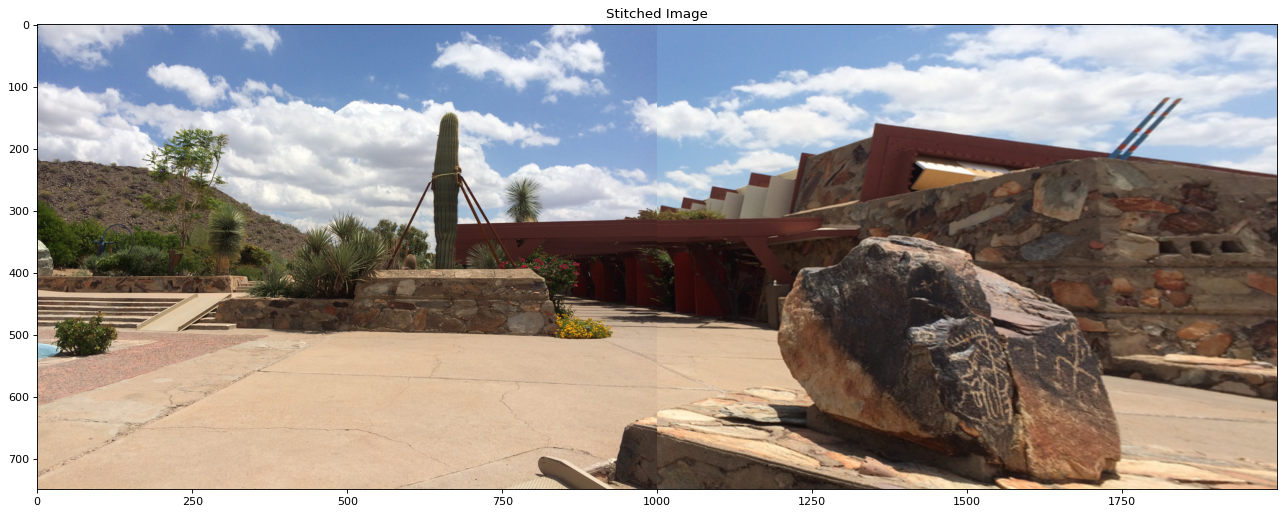

In [219]:
dir_name='Image_Mosaicing'
images=get_file_names(dir_name,3)
img1 = cv2.imread(images[0]) 
img2 = cv2.imread(images[1])
res = stitch(img1, img2)
res = cv2.cvtColor(res,cv2.COLOR_BGR2RGB)
fig = plt.figure(figsize=(20,20),dpi=80)
plt.imshow(res)
plt.title("Stitched Image")
plt.show()

The detectandCompute function takes in the image and returns the respective keypoints and their corresponding feature descriptors.The BruteForce matcher returns an array of matching pairs of descriptors. A ratio of 0.8 is used to get the best matches.

We now use these matching co-ordinates to get the homography matrix in a ransac method. The one having the least reconstruction error is considered as our H matrix. With this H matrix now we use warpPerspective to get image 2 into image 1's plane and then both the images are stitched together by simply overlaying one image1 over the transformed image2. The black regions are taken care by simply cropping the columns which sum up to zero.

# Results on Sample Images(Stitching Multiple Images)

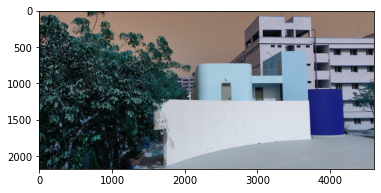

In [34]:
image_names=get_file_names(dir_name,1)
images=[]
for i in range(len(image_names)):
    images.append(cv2.imread(image_names[i]))
plt.imshow(images[0])

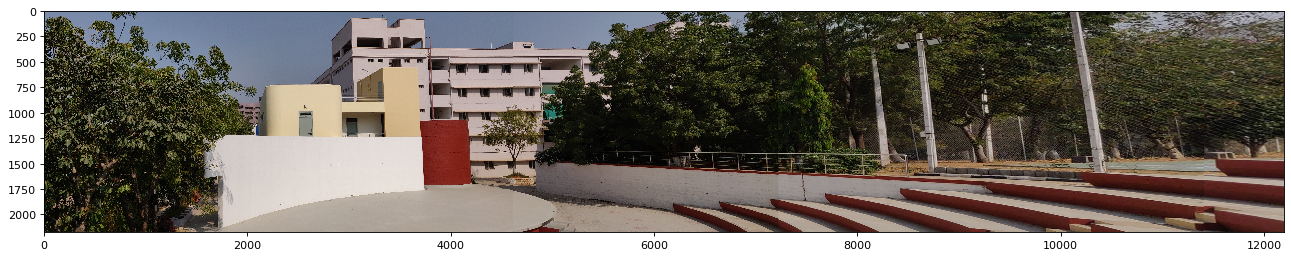

In [40]:
final_image = stitch(images[0],stitch(images[1],stitch(images[2],images[3])))
fig = plt.figure(figsize=(20,20))
final_image = cv2.cvtColor(final_image ,cv2.COLOR_BGR2RGB)
plt.imshow(final_image )
plt.show()

In [35]:
image_names=get_file_names(dir_name,2)
images=[]
for i in range(len(image_names)):
    images.append(cv2.imread(image_names[i]))
plt.imshow(images[0])

In [36]:
final_image = stitch(stitch(stitch(images[3],stitch(stitch(images[0],images[1]),images[2])),images[4]),images[5])

In [37]:
fig = plt.figure(figsize=(20,20),dpi=80)
finalIm2 = cv2.cvtColor(finalIm2,cv2.COLOR_BGR2RGB)
plt.imshow(final_image)
plt.show()

In [37]:
image_names=get_file_names(dir_name,4)
images=[]
for i in range(len(image_names)):
    images.append(cv2.imread(image_names[i]))

In [41]:
final_image = stitch(images[0],images[1])

In [42]:
fig = plt.figure(figsize=(10,10))
final_image = cv2.cvtColor(final_image,cv2.COLOR_BGR2RGB)
plt.imshow(final_image)
plt.show()

# Result on Own Images

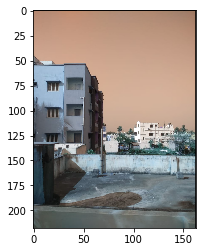

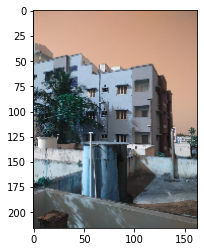

In [49]:
image_names=get_file_names(dir_name,'my')
images=[]
for i in range(len(image_names)):
    images.append(cv2.imread(image_names[i]))
# print(image_names)
for im in images:
    im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
plt.imshow(images[0])
plt.show()
plt.imshow(images[1])
plt.show()

In [51]:
final_image = stitch(images[1],images[0])

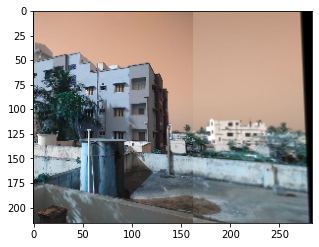

In [54]:
fig = plt.figure(figsize=(5,5))
plt.imshow(final_image)
plt.show()

# Question-2

In [211]:
def correlation_matching(img1,img2,window_sz=32,stride=32):
    h1,w1,_ = img1.shape
    h2,w2,_ = img2.shape
    out= []
    for p in range(0,h1-window_sz,stride):
        for q in range(0,w1-window_sz,stride):
            max_cor  = 0
            for r in range(0,h2-window_sz,stride):
                for s in range(0,w2-window_sz,stride):
                    v1 = img1[p:p+window_sz, q:q+window_sz,:].flatten()
                    v2 = img2[r:r+window_sz, s:s+window_sz,:].flatten()
                    cor = v1.T.dot(v2)
                    mag1= np.sqrt(v1.T.dot(v1))
                    mag2= np.sqrt(v2.T.dot(v2))
                    cor = cor/(10**-8+(mag1*mag2))
                    if cor>max_cor:
                        max_cor = cor
                        pt = [p,q,r,s]
            out.append(pt)
    return out

In [212]:
def draw(img,matches,window_size=32):
    h,w,c = img.shape
    for match in matches:
        pt1 = (match[1]+window_size//2,match[0]+window_size//2)
        pt2 = (match[3]+window_size//2+w//2,match[2]+ window_size//2)
        line_img = cv2.line(img,pt1,pt2,(0,0,225),1)
    return line_img
def drawlines(img1,img2,lines,pts1,pts2):
    r,c,_ = img1.shape
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1

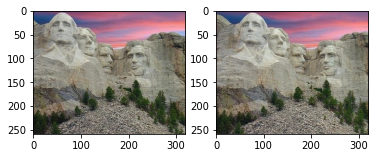

In [208]:
image_names=get_file_names('stereo_correspondence',1)
images=[]
# print(image_names)
for i in range(len(image_names)):
    images.append(cv2.cvtColor(cv2.imread(image_names[i]),cv2.COLOR_BGR2RGB))
    plt.subplot(1,2,i+1)
    plt.imshow(images[i])
plt.show()
img1=images[0]
img2=images[1]

In [158]:
img = np.concatenate((img1,img2),axis=1)
print(img.shape)
print(img1.shape)
print(img2.shape)

(259, 640, 3)
(259, 320, 3)
(259, 320, 3)


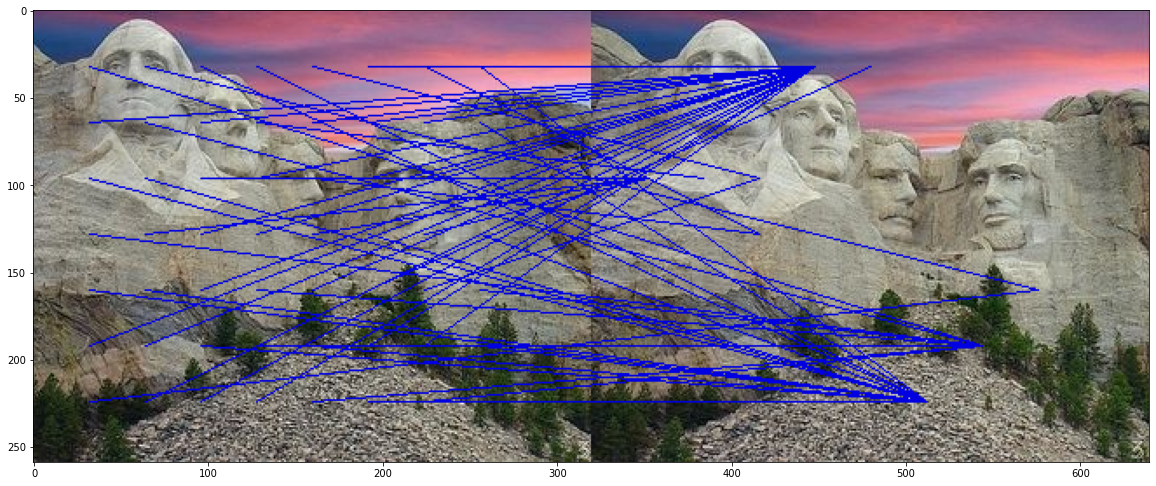

In [209]:
matches = correlation_matching(img1,img2,64,32)
out = draw(img,matches,64)
fig = plt.figure(figsize=(20,20))
plt.imshow(out)

In [152]:
key1,key2,matching_inds = match(img1,img2)
pts1,pts2 =  get_coords(key1, key2, matching_inds)
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.RANSAC)
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]
# print(matching_inds[:5])

## Epipolar lines on sample image

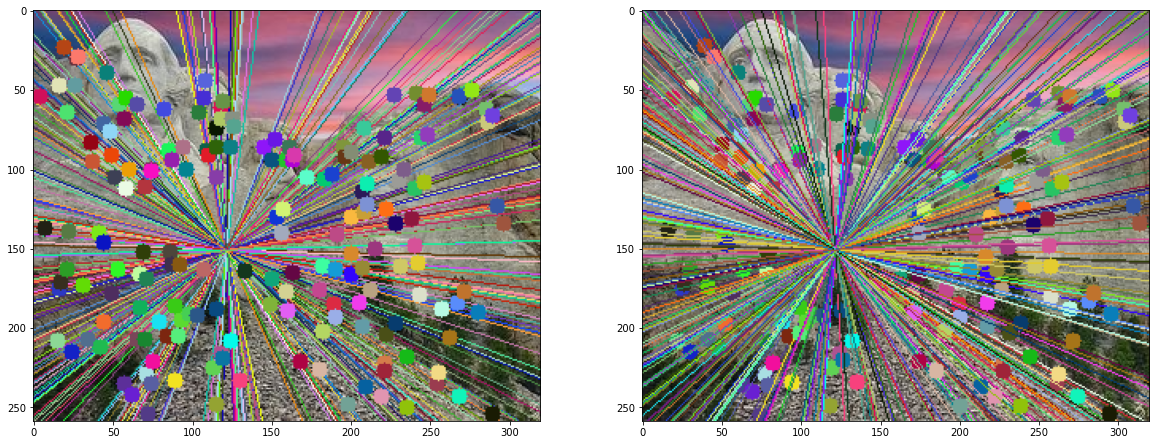

In [151]:
one = np.ones((pts1.shape[0],1))
pts1_h = np.hstack((pts1,one))
pts2_h = np.hstack((pts2,one))
lines1 = np.dot(pts2_h,F)
lines2 = np.dot(pts1_h,F)
out1 = drawlines(img1,img2,lines1,pts1,pts2)
out2 = drawlines(img2,img1,lines2,pts2,pts1)
fig = plt.figure(figsize=(20,20))
plt.subplot(121),plt.imshow(out1)
plt.subplot(122),plt.imshow(out2)
plt.show()

## Rectification on sample Images

In [160]:
def stereoRectification(im1,im2):
    key1,key2,matching_inds = match(im1,im2)
    pts1,pts2 =  get_coords(key1, key2, matching_inds)
    pt1 = np.int32(pts1)
    pt2 = np.int32(pts2)
    F, mask = cv2.findFundamentalMat(pt1,pt2,cv2.RANSAC)

    pts1 = pts1[mask.ravel()==1]
    pts2 = pts2[mask.ravel()==1]
    h,w,_ = img1.shape
 
    p,H1,H2=cv2.stereoRectifyUncalibrated(pts1, pts2, F, (w,h))
        
    im1_rect = cv2.warpPerspective(im1, H1,(w,h))
    im2_rect = cv2.warpPerspective(im2, H2, (w,h))
    return im1_rect,im2_rect

In [189]:
img1_rect,img2_rect = stereoRectification(img1,img2)

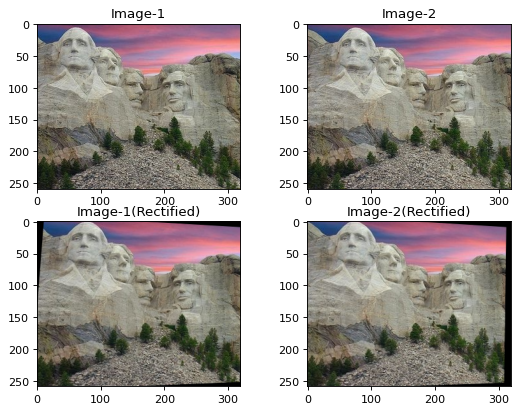

In [190]:
images=[img1,img2,img1_rect,img2_rect]
titles=["Image-1","Image-2","Image-1(Rectified)","Image-2(Rectified)"]
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
for i in range(len(images)):
    plt.subplot(2,2,i+1,title=titles[i])
    plt.imshow(images[i])
plt.show()

In [195]:
image_names=get_file_names('stereo_correspondence',2)
images=[]
# print(image_names)
plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
for i in range(len(image_names)):
    images.append(cv2.cvtColor(cv2.imread(image_names[i]),cv2.COLOR_BGR2RGB))
    plt.subplot(1,2,i+1)
    plt.imshow(images[i])
plt.show()
img1=images[0]
img2=images[1]

In [196]:
img1_rect,img2_rect = stereoRectification(img1,img2)

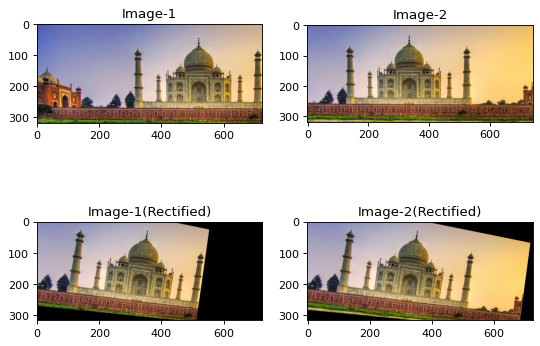

In [198]:
images=[img1,img2,img1_rect,img2_rect]
titles=["Image-1","Image-2","Image-1(Rectified)","Image-2(Rectified)"]
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
for i in range(len(images)):
    plt.subplot(2,2,i+1,title=titles[i])
    plt.imshow(images[i])
plt.show()

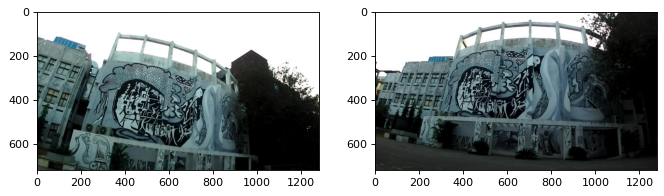

In [200]:
image_names=get_file_names('stereo_correspondence',3)
images=[]
# print(image_names)
plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
for i in range(len(image_names)):
    images.append(cv2.cvtColor(cv2.imread(image_names[i]),cv2.COLOR_BGR2RGB))
    plt.subplot(1,2,i+1)
    plt.imshow(images[i])
plt.show()
img1=images[0]
img2=images[1]

In [203]:
img1_rect,img2_rect = stereoRectification(img1,img2)

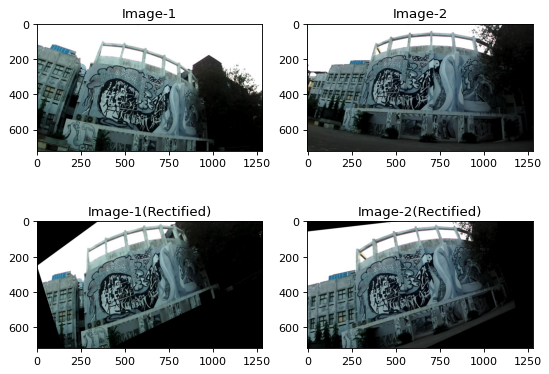

In [204]:
images=[img1,img2,img1_rect,img2_rect]
titles=["Image-1","Image-2","Image-1(Rectified)","Image-2(Rectified)"]
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
for i in range(len(images)):
    plt.subplot(2,2,i+1,title=titles[i])
    plt.imshow(images[i])
plt.show()